In [4]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

# Models to try
from statsmodels.tsa.arima.model import ARIMA
# xgboost
import xgboost
print("xgboost", xgboost.__version__)
from xgboost import XGBRegressor

xgboost 1.6.1


In [2]:
plant_1_generation = pd.read_csv('../data/Plant_1_Generation_Data.csv') 
plant_1_weather_sensor = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv') 
plant_2_generation = pd.read_csv('../data/Plant_2_Generation_Data.csv')
plant_2_weather_sensor = pd.read_csv('../data/Plant_2_Weather_Sensor_Data.csv') 

In [3]:
plant_1_weather_sensor.dtypes

DATE_TIME               object
PLANT_ID                 int64
SOURCE_KEY              object
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
dtype: object

In [199]:
plant_1_generation['DATE_TIME'] = pd.to_datetime(plant_1_generation['DATE_TIME'])
plant_1_weather_sensor['DATE_TIME'] = pd.to_datetime(plant_1_weather_sensor['DATE_TIME'])
plant_2_generation['DATE_TIME'] = pd.to_datetime(plant_1_generation['DATE_TIME'])
plant_2_weather_sensor['DATE_TIME'] = pd.to_datetime(plant_2_weather_sensor['DATE_TIME'])

In [200]:
print(plant_1_generation.info())
print(plant_2_generation.info())
print(plant_1_weather_sensor.info())
print(plant_2_weather_sensor.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    67698 non-null  datetime64[ns]
 1   PLANT_ID     67698 non-null  int64         
 2   SOURCE_KEY   67698 non-null  object        
 3   DC_POWE

## Inital Notes:
- Data does not have any nulls
- Data is structured as timeseries
- Separation between power plant 1 and 2, with power plant 2 having less observations

In [201]:
plant_generation = pd.concat([plant_1_generation, plant_2_generation])

plant_generation['DATE'] = pd.to_datetime(plant_generation["DATE_TIME"]).dt.date
plant_generation['TIME'] = pd.to_datetime(plant_generation["DATE_TIME"]).dt.time

# Baseline Model
#### Note: Multivariate timeseries problem potentially
If we want to predict based off of time then we need to preserve the integrity of the timeseries data and cannot utilize a random train/test split (as we need the dates in order). We can eventually use k-folds for our train test splits but for the baseline we can manually provide that split 

In [202]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [214]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [217]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [221]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

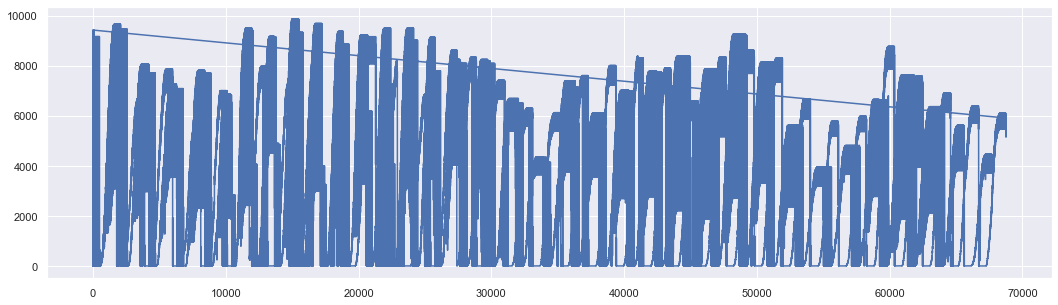

In [211]:

# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = plant_generation['DATE']
values = plant_generation['DAILY_YIELD']
# plot dataset
plt.figure(figsize=(18, 5))
pyplot.plot(values)
pyplot.show()

In [212]:
plant_generation_univarate = plant_generation[['DATE','DAILY_YIELD']]
plant_generation_univarate

,DATE,DAILY_YIELD
0,2020-05-15,0.0
1,2020-05-15,0.0
2,2020-05-15,0.0
3,2020-05-15,0.0
4,2020-05-15,0.0
...,...,...
67693,2020-06-17,4157.0
67694,2020-06-17,3931.0
67695,2020-06-17,4322.0
67696,2020-06-17,4218.0


In [226]:
# load the dataset
series = plant_generation_univarate
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

TypeError: float() argument must be a string or a number, not 'datetime.date'

In [ ]:
# K-folds test validation split
# X = plant_generation['DATE_TIME']
# y = plant_generation['TOTAL_YIELD']
# tscv = TimeSeriesSplit()
# print(tscv)
# TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [161]:
features = ['PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'DATE', 'TIME']

train_split = int(plant_generation.shape[0]*0.75)
train_power_df = plant_generation[:train_split]
test_power_df = plant_generation[train_split:]

# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
train_power_features = train_power_df[features]
test_power_features = test_power_df[features]
train_power_labels = train_power_df['DAILY_YIELD']
test_power_labels = test_power_df['DAILY_YIELD']

# Confirm the data shapes are as expected.
print('train data shape:', train_power_features.shape)
print('train labels shape:', train_power_labels.shape)
print('test data shape:', test_power_features.shape)
print('test labels shape:', test_power_labels.shape)

train data shape: (102357, 7)
train labels shape: (102357,)
test data shape: (34119, 7)
test labels shape: (34119,)


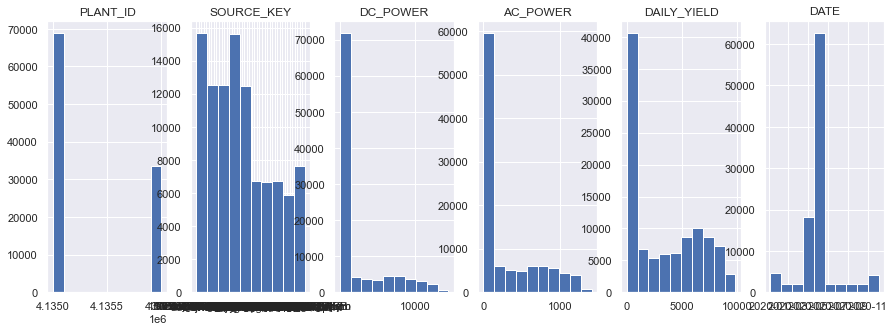

In [158]:
plt.figure(figsize=(15, 5))
for i in range(len(features) - 1):
  plt.subplot(1, 6, i+1)
  plt.hist(np.array(train_power_df[features[i]]))
  plt.title(features[i])
plt.show()

In [159]:
train_power_df.groupby(['PLANT_ID']).count()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE,TIME
PLANT_ID,,,,,,,,
4135001,68778,68778,68778,68778,68778,68778,68778,68778
4136001,33579,33579,33579,33579,33579,33579,33579,33579


In [160]:
train_power_df['DATE_TIME'].dtype

dtype('<M8[ns]')

In [141]:
type(train_power_df['DATE_TIME'])

pandas.core.series.Series

In [127]:
test_power_df.groupby(['DATE']).count()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME
DATE,,,,,,,,
2020-06-01,349,349,349,349,349,349,349,349
2020-06-02,2112,2112,2112,2112,2112,2112,2112,2112
2020-06-03,2090,2090,2090,2090,2090,2090,2090,2090
2020-06-04,2112,2112,2112,2112,2112,2112,2112,2112
2020-06-05,2112,2112,2112,2112,2112,2112,2112,2112
2020-06-06,2112,2112,2112,2112,2112,2112,2112,2112
2020-06-07,2112,2112,2112,2112,2112,2112,2112,2112
2020-06-08,2112,2112,2112,2112,2112,2112,2112,2112
2020-06-09,2112,2112,2112,2112,2112,2112,2112,2112


In [124]:
# Flag: DC_POWER average much lower at plant 4136001
train_power_df.groupby(['PLANT_ID']).mean()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
PLANT_ID,,,,
4135001,3147.426211,307.802752,3295.968737,6.978712e+06
4136001,274.982680,268.839328,3351.859678,6.816273e+08


In [125]:
# Flag: DC_POWER std much lower at plant 4136001, with total yield having a larger spread as well
train_power_df.groupby(['PLANT_ID']).std()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
PLANT_ID,,,,
4135001,4036.457169,394.396439,3145.178309,4.162720e+05
4136001,407.042997,397.652625,3216.142443,7.408225e+08


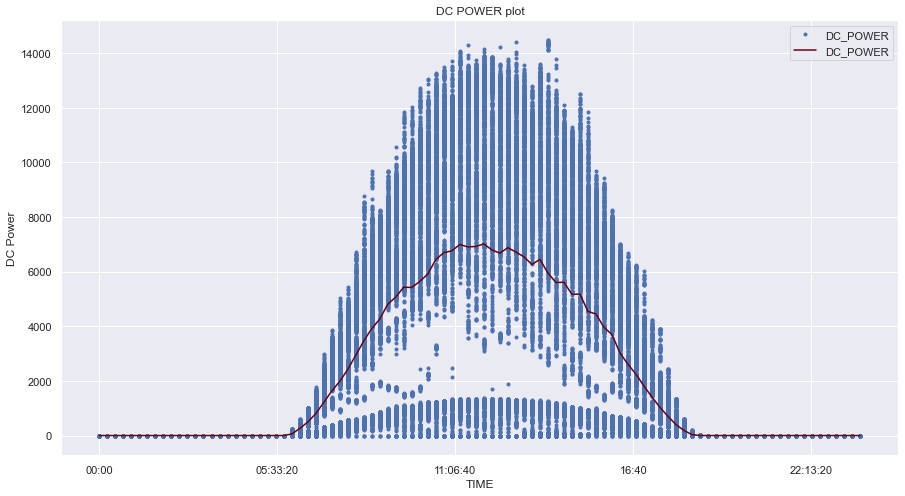

In [86]:
train_power_df.plot(x= 'TIME', y='DC_POWER', style='.', figsize = (15, 8))
train_power_df.groupby('TIME')['DC_POWER'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.ylabel('DC Power')
plt.title('DC POWER plot')
plt.show()

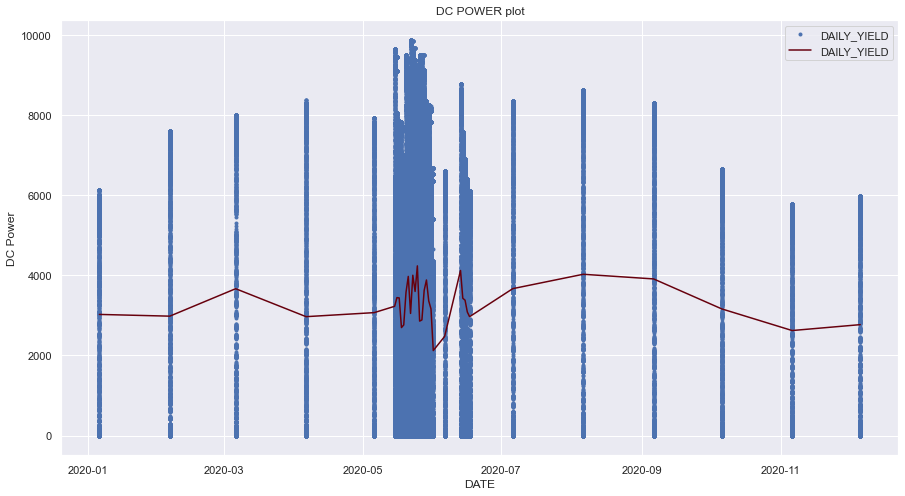

In [89]:
train_power_df.plot(x= 'DATE', y='DAILY_YIELD', style='.', figsize = (15, 8))
train_power_df.groupby('DATE')['DAILY_YIELD'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.ylabel('DC Power')
plt.title('DC POWER plot')
plt.show()